In [1]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics, get_n_columns, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import SuperTrend
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [2]:
class super_reversion_strat():
    def __init__(
        self,
        df,
        st_short_atr_window = 15,
        st_short_atr_multiplier = 5,
        short_ema_window = 10,
        long_ema_window = 200,
    ):
        self.df = df
        self.st_short_atr_window = st_short_atr_window
        self.st_short_atr_multiplier = st_short_atr_multiplier
        self.short_ema_window = short_ema_window
        self.long_ema_window = long_ema_window
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        df = self.df
        df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
        
        # -- Populate indicators --
        super_trend = SuperTrend(
            df['high'], 
            df['low'], 
            df['close'], 
            self.st_short_atr_window, 
            self.st_short_atr_multiplier
        )

        

        
        df['super_trend_direction'] = super_trend.super_trend_direction()
        df['ema_short'] = ta.trend.ema_indicator(close=df['close'], window=self.short_ema_window)
        df['ema_long'] = ta.trend.ema_indicator(close=df['close'], window=self.long_ema_window)
        
        df = get_n_columns(df, ["super_trend_direction", "ema_short", "ema_long"], 1)
        
        # -- Log --
        if(show_log):
            print(df)
        
        self.df = df    
        return self.df
        
    
    def populate_buy_sell(self, show_log=False): 
        df = self.df
        # -- Initiate populate --
        df["open_long_limit"] = False
        df["close_long_limit"] = False
        
        # -- Populate open long limit --
        df.loc[
            (df['n1_ema_short'] >= df['n1_ema_long']) 
            & (df['n1_super_trend_direction'] == True) 
            & (df['n1_ema_short'] > df['low']) 
            , "open_long_limit"
        ] = True
        
        # -- Populate close long limit --
        df.loc[
            ((df['n1_ema_short'] <= df['n1_ema_long'])
            | (df['n1_super_trend_direction'] == False))
            & (df['n1_ema_short'] < df['high'])
            , "close_long_limit"
        ] = True
        
        # -- Log --
        if(show_log):
            print("Open LONG length :",len(df.loc[df["open_long_limit"]==True]))
            print("Close LONG length :",len(df.loc[df["close_long_limit"]==True]))
        
        self.df = df   
        return self.df
        
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        dt = self.df[:]
        wallet = initial_wallet
        maker_fee = 0.001
        taker_fee = 0.001
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_position = None
        
        for index, row in dt.iterrows():
            
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                if current_position:
                    if current_position['side'] == "LONG":
                        close_price = row['close']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        temp_wallet += temp_wallet * trade_result
                        fee = temp_wallet * taker_fee
                        temp_wallet -= fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day

            if current_position:
            # -- Check for closing position --
                if current_position['side'] == "LONG":                     

                    # -- Close LONG limit --
                    if row['close_long_limit']:
                        close_price = row['n1_ema_short']
                        trade_result = (close_price - current_position['price']) / current_position['price']
                        wallet += wallet * trade_result
                        fee = wallet * maker_fee
                        wallet -= fee
                        trades.append({
                            "open_date": current_position['date'],
                            "close_date": index,
                            "position": "LONG",
                            "open_reason": current_position['reason'],
                            "close_reason": "Limit",
                            "open_price": current_position['price'],
                            "close_price": close_price,
                            "open_fee": current_position['fee'],
                            "close_fee": fee,
                            "open_trade_size":current_position['size'],
                            "close_trade_size": wallet,
                            "wallet": wallet
                        })
                        current_position = None

            # -- Check for opening position --
            else:
                # Open LONG limit
                if row['open_long_limit']:
                    open_price = row['n1_ema_short']
                    fee = wallet * maker_fee
                    wallet -= fee
                    pos_size = wallet
                    current_position = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee":fee,
                        "reason": "Limit",
                        "side": "LONG"
                    }
                    
                    
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days
            }  
        else:
            return True   
        

In [3]:
pair = "LTC/USDT"
tf = "1h"

df = get_historical_from_db(
    ccxt.binance(), 
    pair,
    tf,
    path="../../database/"
)

Period: [2017-12-13 00:00:00] -> [2022-05-18 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 15213.93 $
Performance vs US dollar: 1421.39 %
Sharpe Ratio: 1.31
Worst Drawdown T|D: -22.47% | -27.0%
Buy and hold performance: -73.37 %
Performance vs buy and hold: 5612.99 %
Total trades on the period: 153
Global Win rate: 31.37 %
Average Profit: 2.3 %

Best trades: +60.91 % the 2021-02-02 11:00:00 -> 2021-02-21 08:00:00
Worst trades: -10.56 % the 2020-05-07 21:00:00 -> 2020-05-10 07:00:00


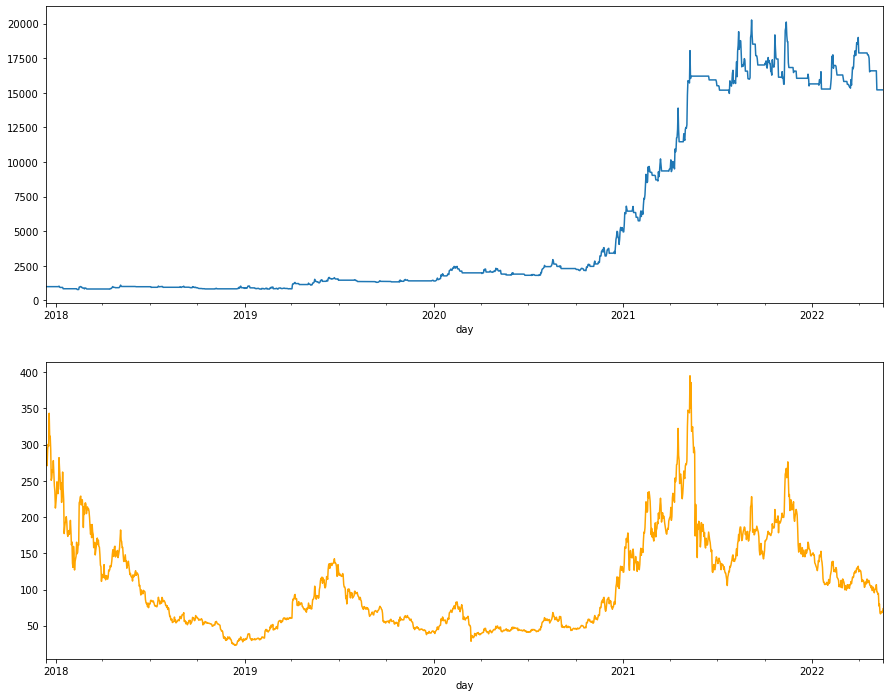

In [4]:
strat = super_reversion_strat(
    df = df.loc[:],
    st_short_atr_window=15,
    st_short_atr_multiplier=5,
    short_ema_window=5,
    long_ema_window=400
)

strat.populate_indicators()
strat.populate_buy_sell(show_log=False)
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")
df_trades, df_days = basic_single_asset_backtest(trades=bt_result['trades'], days=bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

----- 2017 Cumulative Performances: 0.0% -----


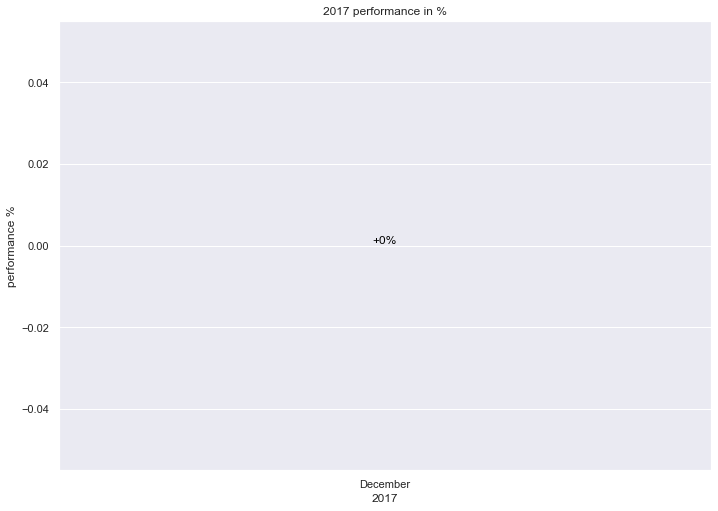

----- 2018 Cumulative Performances: -8.63% -----


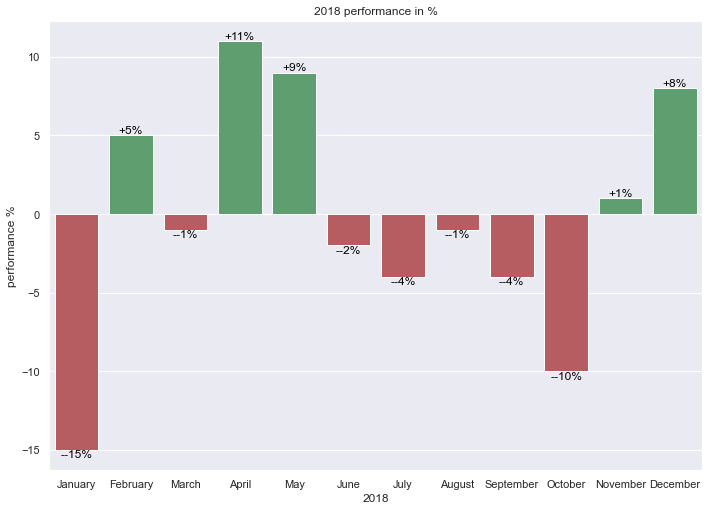

----- 2019 Cumulative Performances: 66.64% -----


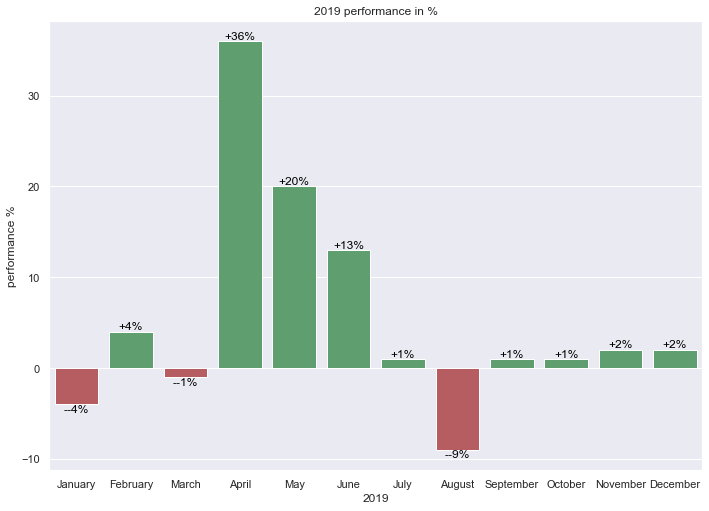

----- 2020 Cumulative Performances: 262.66% -----


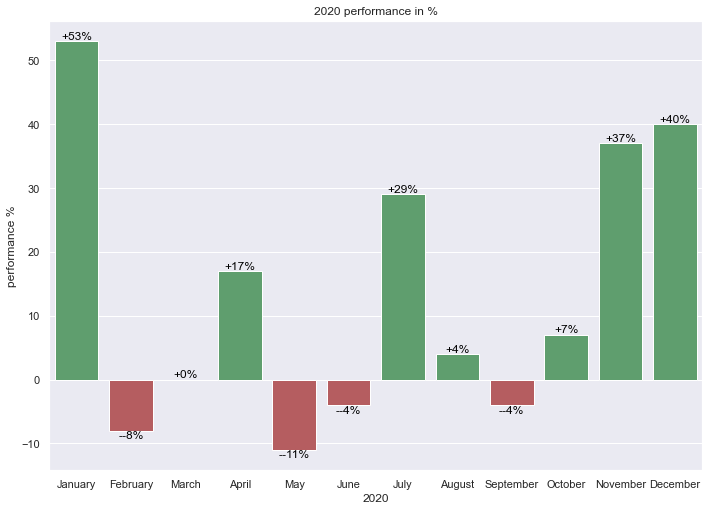

----- 2021 Cumulative Performances: 216.16% -----


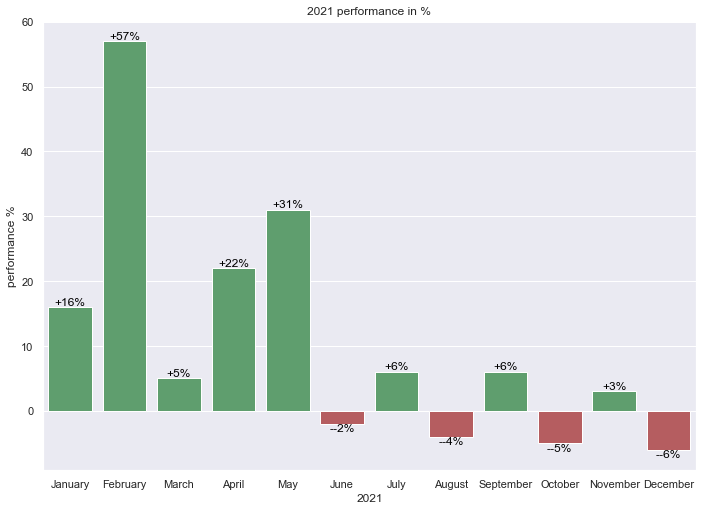

----- 2022 Cumulative Performances: -2.76% -----


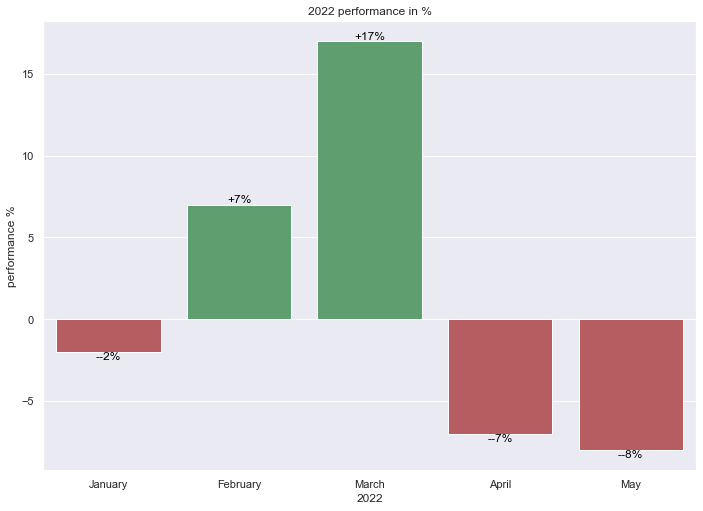

In [5]:
plot_bar_by_month(df_days=df_days)